# Basic Concepts

Introduction to systematic/algorithmic trading.

## Russell 2000 Index

In [2]:
import os
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

# Define the path to the /src directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Check if the path is already in sys.path to avoid duplication
if src_path not in sys.path:
    sys.path.append(src_path)

from modules.portfolio import sharpe_ratio

In [ ]:
rut_df = pd.read_csv('../mock_data/RUT.csv', index_col='Date', parse_dates=True)

<Axes: title={'center': 'Adjusted Close of Russell 2000 Index'}, xlabel='Date'>

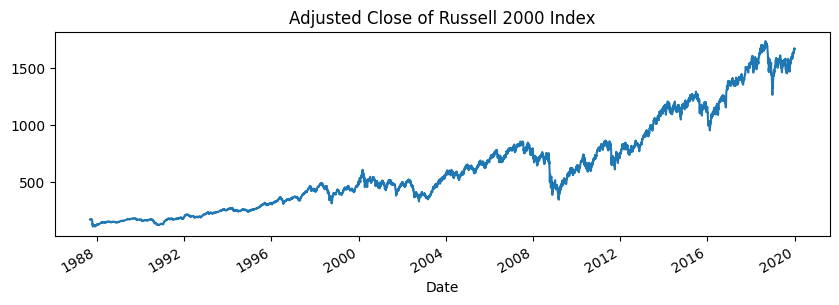

In [3]:
plt.figure(figsize=(10,3), dpi=100)
plt.title("Adjusted Close of Russell 2000 Index")
rut_df['Adj Close'].plot(kind='line')

## Sharpe Ratio

- The Sharpe Ratio is a measure used to assess the risk-adjusted return of an investment or portfolio.
- It indicates how much excess return is received for the extra volatility (risk) endured by holding a risky asset compared to a risk-free asset.
- **Formula**
  - $\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$
- **Where**:
  - $R_p$ = Return of the portfolio or investment
  - $R_f$ = Risk-free rate (return of a risk-free asset, like government bonds)
  - $\sigma_p$ = Standard deviation of the portfolio’s excess return (a measure of risk)
- **Interpretation**
  - **Sharpe Ratio > 1**: Indicates a good risk-adjusted return.
  - **Sharpe Ratio = 1**: Indicates an acceptable risk-adjusted return (S&P 500)
  - **Sharpe Ratio < 1**: Indicates a poor risk-adjusted return.
  - Higher Sharpe Ratios (>2) are preferred as they imply better risk-adjusted performance.
- **Limitations**
  - **Assumes Normal Distribution**: The Sharpe Ratio assumes that returns are normally distributed, which may not always be the case.
  - **Ignores Skewness and Kurtosis**: It does not account for the potential for extreme events (tail risks) in the distribution of returns.
  - **Static Measure**: It is a snapshot and does not account for changes in risk or market conditions over time.

In [4]:
rut_df['Daily Return'] = rut_df['Adj Close'].pct_change(1)
rut_df = rut_df.dropna() # drops first row where Daily Return is NaN

In [5]:
rut_std = rut_df['Daily Return'].std()

In [6]:
def compute_sharpe_ratio(
    df,
    daily_return_column="Daily Return",
    risk_free_rate: float = 0.0,
    is_annual_ratio: bool = True,
):

    mean_return = df[daily_return_column].mean()
    std = rut_df[daily_return_column].std()

    sharpe_ratio = (mean_return - risk_free_rate) / std

    return sharpe_ratio * (252 ** 0.5) if is_annual_ratio else sharpe_ratio


compute_sharpe_ratio(rut_df)

0.4507934255302507

## Sortino Ratio

- The Sortino Ratio is a performance measurement tool used to evaluate the risk-adjusted return of an investment or portfolio.
- Unlike the Sharpe Ratio, which considers both upside and downside volatility, the Sortino Ratio focuses specifically on downside risk, providing a clearer view of the investment's performance in adverse conditions.
- **Formula**
  - $\text{Sortino Ratio} = \frac{R_p - R_t}{\sigma_d}$
- **Where:**
  - $R_p$ = Return of the portfolio or investment
  - $R_t$ = Target return (usually the risk-free rate or a minimum acceptable return)
  - $\sigma_d$ = Downside deviation (standard deviation of negative returns)
- **Interpretation**
  - **Sortino Ratio > 1**: Indicates good risk-adjusted performance considering downside risk.
  - **Sortino Ratio = 1**: Indicates an acceptable level of risk-adjusted return.
  - **Sortino Ratio < 1**: Indicates poor performance when factoring in downside risk.
  - Higher Sortino Ratios (>2) are preferred as they imply better performance relative to the risk of negative returns.
- **Advantages**
  - **Focus on Downside Risk**: By measuring only downside volatility, it provides a more accurate picture of risk for risk-averse investors.
  - **Target Return Flexibility**: Allows investors to set their own target return, making it adaptable to individual investment goals.
- **Limitations**
  - **Requires More Data**: Calculation of downside deviation requires historical return data and can be complex.
  - **Target Dependency**: The choice of the target return can significantly influence the Sortino Ratio, making comparisons across different investments potentially misleading.
  - **Ignores Upside Potential**: By focusing solely on downside risk, it may overlook positive performance in volatile markets.

In [7]:
def compute_sortino_ratio(
    df,
    daily_return_column="Daily Return",
    threshold: float=0.0,
    risk_free_rate: float = 0.0,
    is_annual_ratio: bool = True,
):

    mean_return = df[daily_return_column].mean()
    downside_std = df[df[daily_return_column] < threshold][daily_return_column].std() # only returns below threshold

    sharpe_ratio = (mean_return - risk_free_rate) / downside_std

    return sharpe_ratio * (252 ** 0.5) if is_annual_ratio else sharpe_ratio


compute_sortino_ratio(rut_df)

0.570034198159496

## Probabilistic Sharpe Ratio

- The Probabilistic Sharpe Ratio (PSR) is an enhanced version of the traditional Sharpe Ratio.
- It aims to determine whether the observed Sharpe Ratio is statistically significant or likely to have occurred by chance.
- The PSR accounts for variability and adjusts for the bias that arises when evaluating multiple strategies or periods.
- Assesses the likelihood that a given Sharpe Ratio is a genuine measure of risk-adjusted performance rather than a random occurrence due to variability in returns.
- **Formula**
  - $\widehat{PSR}(SR^{*}) = P\left(\widehat{SR} > SR^{*}\right) = Z\left(\frac{(\widehat{SR} - SR^{\ast})\sqrt{n-1}}{\sqrt{1 - \hat{\gamma}_{3}\widehat{SR} + \frac{\hat{\gamma}_{4}-1}{4}\widehat{SR}^{2}}}\right)$
- **Where**:
    - $\widehat{SR}$ = Observed Sharpe Ratio
    - $SR^*$ = Benchmark Sharpe Ratio (a Sharpe Ratio threshold considered to be acceptable, e.g. 0)
    - $n$ = Number of observations
    - $Z$ = Cumulative distribution function (CDF) of a standard normal distribution
    - $\hat{\gamma}_{3}$ is the observed skewness of the returns
    - $\hat{\gamma}_{4}$ is the observed kurtosis of the returns
- **Interpretation**
  - The PSR outputs a probability value between 0 and 1:
    - **PSR close to 1**: High confidence that the observed Sharpe Ratio exceeds the benchmark and is statistically significant.
    - **PSR close to 0**: Low confidence that the observed Sharpe Ratio is genuinely higher than the benchmark.
  - A higher PSR suggests that the Sharpe Ratio is not due to randomness and is more likely to reflect actual risk-adjusted performance.
- **Advantages**
  - **Adjusts for Bias**: Accounts for the selection bias inherent in choosing multiple strategies based on their high Sharpe Ratios.
  - **More Reliable**: Provides a probabilistic interpretation, making it easier to quantify the confidence in an observed Sharpe Ratio.
- **Limitations**
  - **Complexity**: The PSR is more complex to calculate and interpret than the traditional Sharpe Ratio.
  - **Assumption of Normality**: Similar to the Sharpe Ratio, the PSR assumes that returns are normally distributed, which may not always be true.
  - **Dependence on Benchmark**: The choice of $SR^*$ as the benchmark Sharpe Ratio can significantly affect the interpretation of the PSR.

In [8]:
def compute_probabilistic_sharpe_ratio(
    df,
    daily_return_column='Daily Return',
    risk_free_rate: float = 0.0,
    benchmark_sharpe_ratio: float = 0.0,
    is_annual_ratio: bool = True,
):

    daily_observed_sharpe_ratio = compute_sharpe_ratio(df, daily_return_column, risk_free_rate, is_annual_ratio=False)
    skew = scipy.stats.skew(df[daily_return_column])
    kurtosis = scipy.stats.kurtosis(df[daily_return_column], fisher=False)
    n = len(df)

    numerator = ((daily_observed_sharpe_ratio - benchmark_sharpe_ratio) * (n - 1) ** 0.5)
    denominator = (1 - skew * daily_observed_sharpe_ratio + ((kurtosis - 1) / 4) * (daily_observed_sharpe_ratio ** 2) ) ** 0.5

    probabilistic_sharpe_ratio = scipy.stats.norm.cdf(numerator / denominator)

    return probabilistic_sharpe_ratio * (252 ** 0.5) if is_annual_ratio else probabilistic_sharpe_ratio


compute_probabilistic_sharpe_ratio(rut_df, is_annual_ratio=False)

0.9945474914938986

In [9]:
# compare with src code
sharpe_ratio.probabilistic_sharpe_ratio(rut_df['Daily Return'])

0.9945474914938986

## Portfolio Optimisation


In [4]:
cost_df = pd.read_csv('../mock_data/COST.csv', index_col='Date', parse_dates=True)['Adj Close']
wmt_df = pd.read_csv('../mock_data/WMT.csv', index_col='Date', parse_dates=True)['Adj Close']
tgt_df = pd.read_csv('../mock_data/TGT.csv', index_col='Date', parse_dates=True)['Adj Close']
dg_df = pd.read_csv('../mock_data/DG.csv', index_col='Date', parse_dates=True)['Adj Close']

In [8]:
retail_df = pd.concat([cost_df, wmt_df, tgt_df, dg_df], axis=1)
retail_df.columns = ['COST', 'WMT', 'TGT', 'DG']
retail_df

,COST,WMT,TGT,DG
Date,,,,
2016-09-06,140.896622,65.758080,60.674061,68.342621
2016-09-07,138.739395,64.911324,60.847187,68.105331
2016-09-08,136.805038,64.704163,60.120117,67.080215
2016-09-09,134.335831,63.325943,59.721989,66.994766
2016-09-12,135.218338,64.803238,59.981625,68.366478
...,...,...,...,...
2021-08-27,450.339996,146.520004,249.179993,225.250000
2021-08-30,455.929993,147.699997,249.360001,225.360001
2021-08-31,455.489990,148.100006,246.979996,222.910004


<Axes: xlabel='Date'>

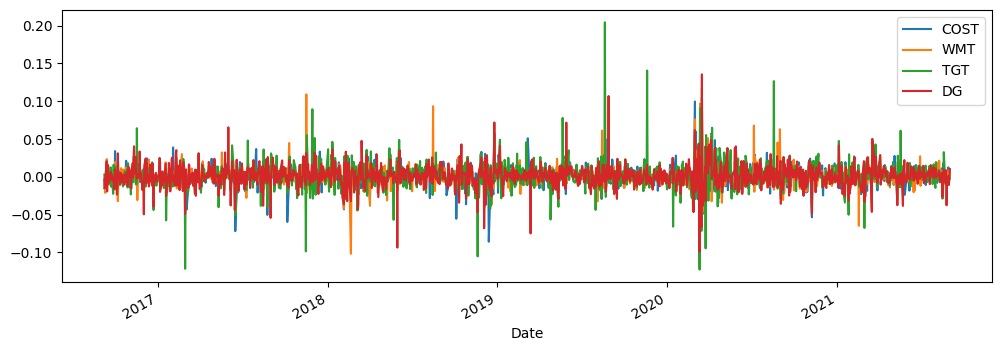

In [13]:
retail_daily_returns_df = retail_df.pct_change(1).dropna()
retail_daily_returns_df.plot(figsize=(12,4))

<Axes: xlabel='Date'>

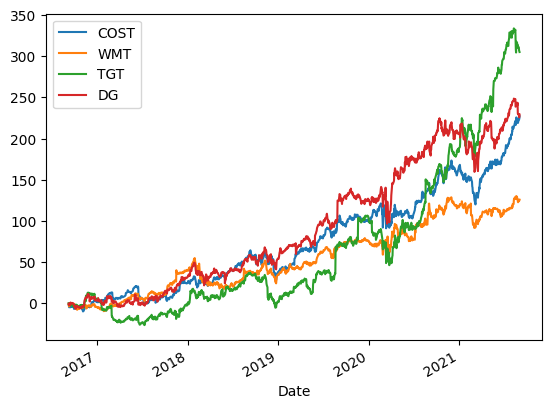

In [17]:
retail_cumulative_returns_df = ((1 + retail_daily_returns_df).cumprod() - 1) * 100
retail_cumulative_returns_df.plot()

[0.25, 0.25, 0.25, 0.25]


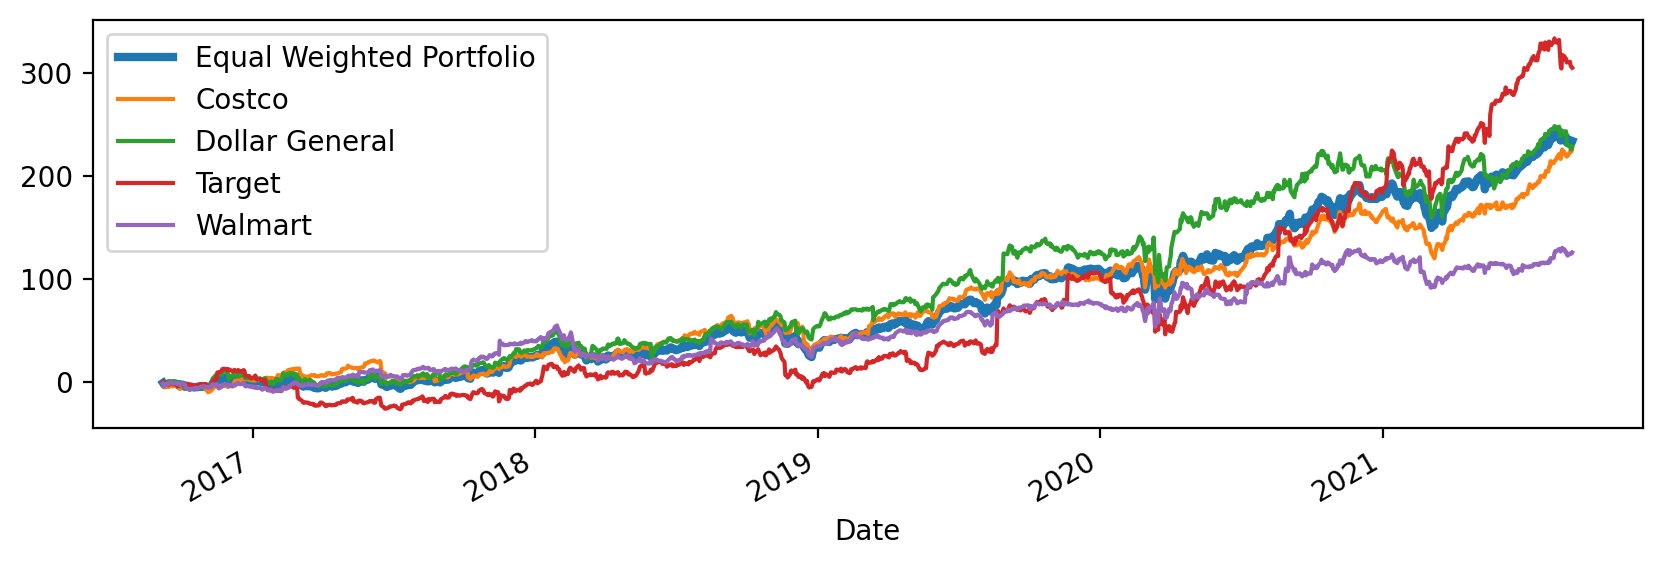

In [52]:
n = len(retail_cumulative_returns_df.columns)
equal_weightings = n * [1 / n]
print(equal_weightings)
retail_weighted_daily_returns = np.dot(equal_weightings, retail_daily_returns_df.transpose())
retail_weighted_cumulative_returns = ((1 + retail_weighted_daily_returns).cumprod()-1) * 100 # np.dot([a, b], [x, y]) => a * x + b * y
retail_weighted_cumulative_returns_series = pd.Series(retail_weighted_cumulative_returns, index=retail_daily_returns_df.index)

plt.figure(figsize=(10,3), dpi=200)
retail_weighted_cumulative_returns_series.plot(label="Equal Weighted Portfolio", linewidth=3)
retail_cumulative_returns_df['COST'].plot(label="Costco")
retail_cumulative_returns_df['DG'].plot(label="Dollar General")
retail_cumulative_returns_df['TGT'].plot(label="Target")
retail_cumulative_returns_df['WMT'].plot(label="Walmart")
plt.legend()